# Data viz for paper submission

In [1]:
# quick prep for proper ipynb viz in VS Code
!uv pip install ipykernel jupyter matplotlib seaborn

Using Python 3.12.12 environment at: /root/openr1_v2
Audited 4 packages in 24ms


In [2]:
# All imports
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Sec 1: Introduction

### Idk yet, probably want a catchy graph opposite abstract!

## Sec 2: Related Works

### Figure 2: Idk, related works probs won't need one?

## Sec 3: Existing Approaches for Mitigating Safety Degradation

In [3]:
# helper function that retrieves scores on safety benchmarks produced by allenai/safety-eval
def retrieve_results(
    results_json_path: str,
    benchmark_configs: list[tuple[str, str]],
    compute_mean: bool = True,
    ):
    """
    Given a string filepath to a JSON file containing results created by safety-eval, and tuples of benchmarks and requested metrics, returns results as list and optionally the mean at the end.

        Args:
            results_json_path (`str`):
                Filepath of safety-eval generated JSON results file.
            benchmark_configs (`list[tuple[str, str]]`):
                List of tuples, each containing a benchmark and associated metric name. 
            compute_mean (`bool`, defaults to `False`):
                Whether or not to append average score at the end.

        Returns:
            Safety benchmark results as a list
    """
    with open(results_json_path) as fp:
        results_dict = json.load(fp)

    scores = []
    for benchmark, score_name in benchmark_configs:
        if benchmark == "wildjailbreak:benign":
            macro_asr = results_dict[benchmark]["macro_asr"]
            # inverted_macro_asr = 1 - macro_asr
            # print(f"found wildjailbreak:benign with macro_asr of {macro_asr}, appending inverted_macro_asr of {inverted_macro_asr} (for {results_json_path})")
            # UPDATE: actually we shouldn't invert this. 
            print(f"WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect")
            scores.append(macro_asr)
        else:
            scores.append(results_dict[benchmark][score_name])
    
    if compute_mean:
        mean = sum(scores) / len(scores)
        scores.append(mean)
        # print(f"Average score for {results_json_path} is {mean}")
    return scores



### Sec 3.1: Lower Learning Rates During Supervised Fine-tuning

In [4]:
# data for MATH-500, IFeval, IFBench from lighteval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

RESULTS = {
    #  Model name                           Version      MATH-500           IFEval             IFBench
    "Base":                                 ("Base",     (0.460, 0.0223),  (0.7024, 0.0197),  (0.2433, 0.0248)),
    "Best low LR SFT":                      ("v00.24",   (0.598, 0.0219),  (0.4843, 0.0215),  (0.1267, 0.0192)),
    # NEED TO ACTUALLY ADD THE RESULTS HERE
}

BENCHMARKS = ["MATH-500", "IFEval", "IFBench"]

**Figure 3: Low LR results - Math**

**Figure 3: Low LR results - Utility**

**Figure 3: Low LR results - Safety**

['wildguardtest', 'harmbench', 'toxigen', 'do_anything_now', 'wildjailbreak:harmful', 'trustllm_jailbreaktrigger', 'xstest', 'Average']
48
48
48


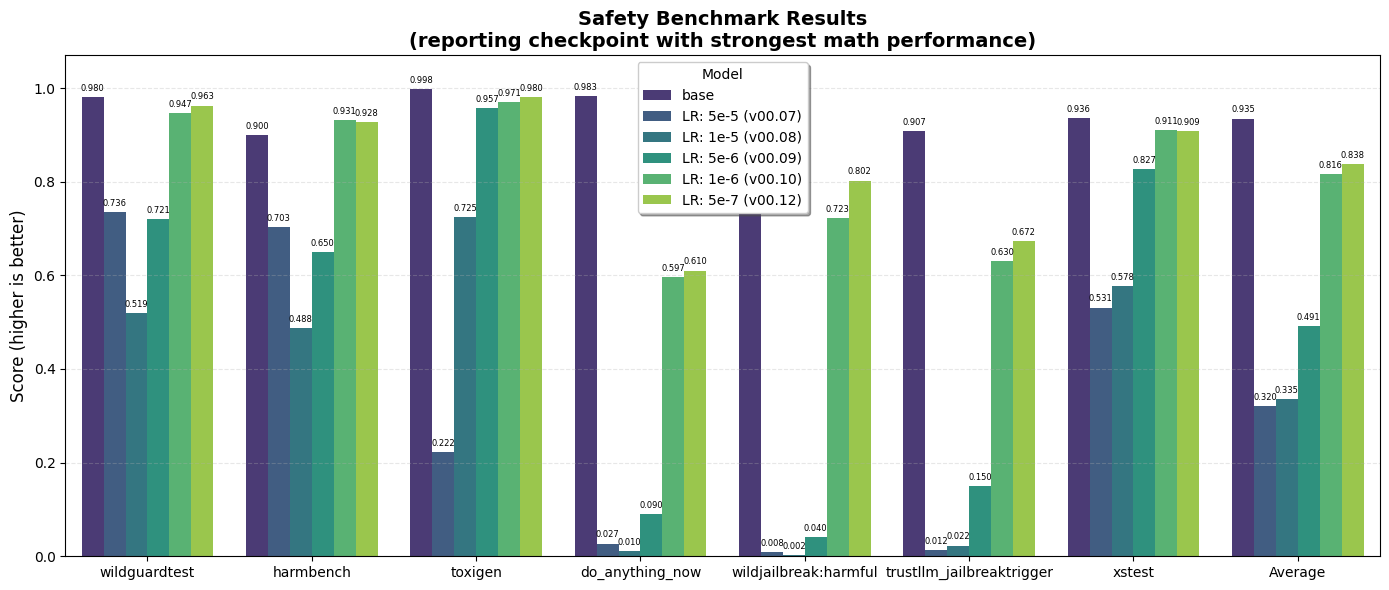

In [5]:
root_file_path = "../safety-eval/generation_results/"
model = "Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00."

safety_benchmark_configs = [
    ('wildguardtest', 'inverted_micro_harm_lower'),
    ('harmbench', 'inverted_micro_asr_lower'),
    ('toxigen', 'safe_overall'),
    ('do_anything_now', 'inverted_macro_asr'),
    ('wildjailbreak:harmful', 'inverted_macro_asr'),
    ('trustllm_jailbreaktrigger', 'inverted_macro_asr'),
    ('xstest', 'overall_accuracy')
]
benchmarks = [benchmark[0] for benchmark in safety_benchmark_configs] + ["Average"]
print(benchmarks)

### do it for base
base_path = root_file_path + "meta-llama/Llama-3.1-8B-Instruct" + "/base/metrics_base_main.json"
base_values = retrieve_results(results_json_path=base_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
low_lr_values = []
for i in range(7,13):
    if i == 11: # the v00.11 run had a bug
        continue
    version_id_unpadded = str(i)
    version_id = "0" + version_id_unpadded if len(version_id_unpadded) == 1 else version_id_unpadded # turning "7" into "07"
    low_lr_path = root_file_path + model + version_id + "/SFT/metrics_SFT_main.json"
    low_lr_values += retrieve_results(results_json_path=low_lr_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
n = 6
print(len(benchmarks * n))
print(len(base_values + low_lr_values))
print(len(['base'] * len(benchmarks) + ['LR: 5e-5 (v00.07)'] * len(benchmarks) + ['LR: 1e-5 (v00.08)'] * len(benchmarks) + ['LR: 5e-6 (v00.09)'] * len(benchmarks)  + ['LR: 1e-6 (v00.10)'] * len(benchmarks) + ['LR: 5e-7 (v00.12)'] * len(benchmarks)))

df = pd.DataFrame({
    'Benchmark': benchmarks * n,
    'Value': base_values + low_lr_values,
    'Model': ['base'] * len(benchmarks) + ['LR: 5e-5 (v00.07)'] * len(benchmarks) + ['LR: 1e-5 (v00.08)'] * len(benchmarks) + ['LR: 5e-6 (v00.09)'] * len(benchmarks)  + ['LR: 1e-6 (v00.10)'] * len(benchmarks) + ['LR: 5e-7 (v00.12)'] * len(benchmarks)
})

fig, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("viridis", n)
bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette)

# again we add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Safety Benchmark Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1 * 1.07) # trying to give room for labels
plt.tight_layout()
plt.show()

### Sec 3.2.1: Performing Low-percentage Replay On Refusals (NO STEPS)

**Figure x: Low percentage replay results**

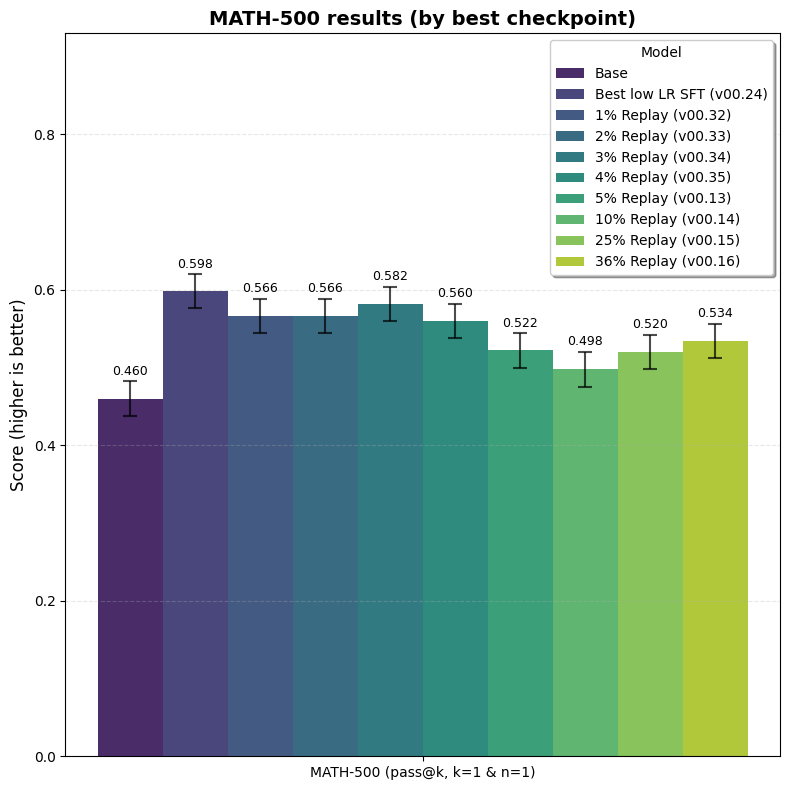

In [6]:
# data for MATH-500, IFeval, IFBench from lighteval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

RESULTS = {
    #  Model name                                   Version      MATH-500           IFEval             IFBench
    "Base":                                         ("Base",     (0.460, 0.0223),  (0.7024, 0.0197),  (0.2433, 0.0248)),
    "Best low LR SFT":                              ("v00.24",   (0.598, 0.0219),  (0.4843, 0.0215),  (0.1267, 0.0192)),
    "1% Replay":                                    ("v00.32",   (0.566, 0.0222),  (0.3604, 0.0207),  (0.1467, 0.0205)),
    "2% Replay":                                    ("v00.33",   (0.566, 0.0222),  (0.4233, 0.0213),  (0.1600, 0.0212)),
    "3% Replay":                                    ("v00.34",   (0.582, 0.0221),  (0.4344, 0.0213),  (0.1767, 0.0221)),
    "4% Replay":                                    ("v00.35",   (0.560, 0.0222),  (0.4455, 0.0214),  (0.1867, 0.0225)),
    "5% Replay":                                    ("v00.13",   (0.522, 0.0224),  (0.4492, 0.0214),  (0.1500, 0.0206)),
    "10% Replay":                                   ("v00.14",   (0.498, 0.0224),  (0.4954, 0.0215),  (0.1700, 0.0217)),
    "25% Replay":                                   ("v00.15",   (0.520, 0.0224),  (0.5619, 0.0214),  (0.1533, 0.0208)),
    "36% Replay":                                   ("v00.16",   (0.534, 0.0223),  (0.5841, 0.0212),  (0.1933, 0.0228)),
}

BENCHMARKS = ["MATH-500", "IFEval", "IFBench"]
rows = []
for name, (version, *scores) in RESULTS.items():
    label = f"{name} ({version})" if name != "Base" else "Base"
    for bench, (val, stderr) in zip(BENCHMARKS, scores):
        rows.append({"Model": label, "Benchmark": bench, "Value": val, "Stderr": stderr})

df = pd.DataFrame(rows)
df = df[df['Benchmark'].isin(['MATH-500'])]

df['Benchmark'] = 'MATH-500 (pass@k, k=1 & n=1)'

fig, ax = plt.subplots(figsize=(8, 8))
n = len(df)
palette = sns.color_palette("viridis", n)

bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette, errorbar=None)

x_pos = []
y_pos = []
errors = []

# adding stderr vals to all bars
for i, container in enumerate(ax.containers):
    for bar in container:
        x_pos.append(bar.get_x() + bar.get_width() / 2)
        y_pos.append(bar.get_height())
    errors.append(df.iloc[i]['Stderr'])
ax.errorbar(x_pos, y_pos, yerr=errors, fmt='none', 
            color='black', capsize=5, capthick=1.5, 
            elinewidth=1.5, alpha=0.7, zorder=10)

# i prefer adding bar labels on top of bars to actually see the values
for container in ax.containers:
    if isinstance(container, BarContainer):
        ax.bar_label(container, fmt='%.3f', padding=15, fontsize=9)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('MATH-500 results (by best checkpoint)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give room for labels and error bars
ax.set_ylim(0, max(df['Value'] + df['Stderr']) * 1.5)

plt.tight_layout()
plt.show()

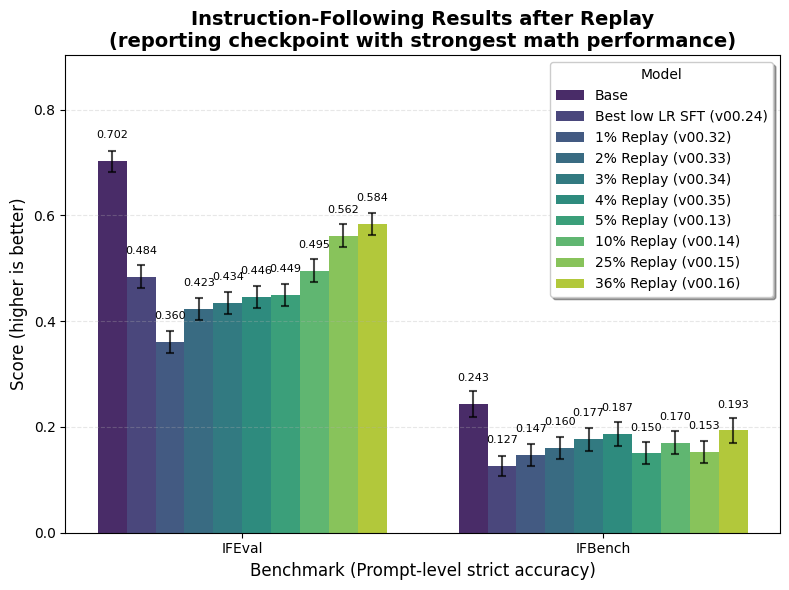

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

rows = []
for name, (version, *scores) in RESULTS.items():
    label = f"{name} ({version})" if name != "Base" else "Base"
    for bench, (val, stderr) in zip(BENCHMARKS, scores):
        rows.append({"Model": label, "Benchmark": bench, "Value": val, "Stderr": stderr})

df = pd.DataFrame(rows)

# we select only instruction following benchmarks
df = df[df['Benchmark'].isin(['IFEval','IFBench'])]
fig, ax = plt.subplots(figsize=(8, 6))
n_models = len(df['Model'].unique())
palette = sns.color_palette("viridis", n_models)

bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette, errorbar=None)

benchmarks = df['Benchmark'].unique()
models = df['Model'].unique()

for i, container in enumerate(ax.containers):
    if isinstance(container, BarContainer):
        for j, bar in enumerate(container):
            model = models[i]
            benchmark = benchmarks[j]
            stderr = df[(df['Model'] == model) & (df['Benchmark'] == benchmark)]['Stderr'].values[0]
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()
            if y > 0:  # Only add error bars for non-zero values
                ax.errorbar(x, y, yerr=stderr, fmt='none',
                           color='black', capsize=3, capthick=1.5,
                           elinewidth=1.5, alpha=0.7, zorder=10)

# adding value labels on top of bars again
for container in ax.containers:
    if isinstance(container, BarContainer):
        labels = [f'{v.get_height():.3f}' if v.get_height() > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, padding=15, fontsize=8, rotation=0)

ax.set_xlabel('Benchmark (Prompt-level strict accuracy)', fontsize=12)
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Instruction-Following Results after Replay\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
# ax.legend(title='Model', frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(1.02, 1), loc='upper left')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give room for labels and error bars
ax.set_ylim(0, max(df['Value'] + df['Stderr']) * 1.25)

plt.tight_layout()
plt.show()

**Figure 4: Replay results**

### Sec 3.2.1: Performing Low-percentage Replay On Refusals (WITH STEPS)

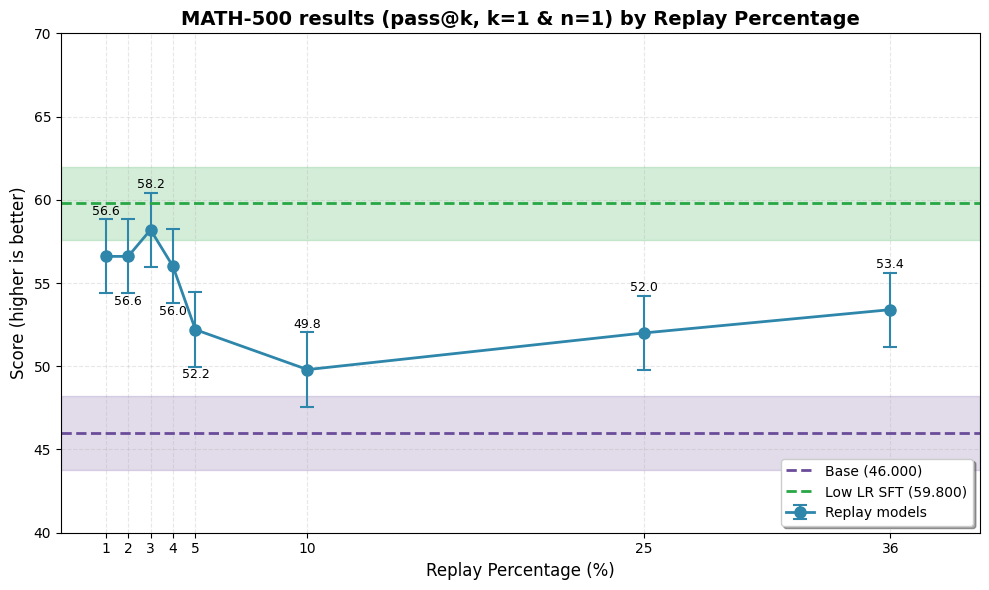

In [8]:
# data for MATH-500, IFeval, IFBench from lighteval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

RESULTS = {
    #  Model name                                   Version      MATH-500           IFEval             IFBench
    "Base":                                         ("Base",     (0.460, 0.0223),  (0.7024, 0.0197),  (0.2433, 0.0248)),
    "Low LR SFT":                                   ("v00.24",   (0.598, 0.0219),  (0.4843, 0.0215),  (0.1267, 0.0192)),
    "1% Replay":                                    ("v00.32",   (0.566, 0.0222),  (0.3604, 0.0207),  (0.1467, 0.0205)),
    "2% Replay":                                    ("v00.33",   (0.566, 0.0222),  (0.4233, 0.0213),  (0.1600, 0.0212)),
    "3% Replay":                                    ("v00.34",   (0.582, 0.0221),  (0.4344, 0.0213),  (0.1767, 0.0221)),
    "4% Replay":                                    ("v00.35",   (0.560, 0.0222),  (0.4455, 0.0214),  (0.1867, 0.0225)),
    "5% Replay":                                    ("v00.13",   (0.522, 0.0224),  (0.4492, 0.0214),  (0.1500, 0.0206)),
    "10% Replay":                                   ("v00.14",   (0.498, 0.0224),  (0.4954, 0.0215),  (0.1700, 0.0217)),
    "25% Replay":                                   ("v00.15",   (0.520, 0.0224),  (0.5619, 0.0214),  (0.1533, 0.0208)),
    "36% Replay":                                   ("v00.16",   (0.534, 0.0223),  (0.5841, 0.0212),  (0.1933, 0.0228)),
}

# Extract replay percentages and MATH-500 scores
percentages = []
scores = []
stderrs = []

for name, (version, math_score, *_) in RESULTS.items():
    if "Replay" in name:
        pct = int(name.split("%")[0])
        percentages.append(pct)
        scores.append(math_score[0] * 100)
        stderrs.append(math_score[1] * 100)

# Get baseline values
base_score = RESULTS["Base"][1][0] * 100
base_stderr = RESULTS["Base"][1][1] * 100
sft_score = RESULTS["Low LR SFT"][1][0] * 100
sft_stderr = RESULTS["Low LR SFT"][1][1] * 100

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line with error bars
ax.errorbar(percentages, scores, yerr=stderrs, fmt='o-', 
            color='#2E86AB', capsize=5, capthick=1.5, 
            elinewidth=1.5, markersize=8, linewidth=2,
            label='Replay models')

# Add horizontal reference lines for Base and Best SFT
ax.axhline(y=base_score, color='#6B4C9A', linestyle='--', linewidth=2, label=f'Base ({base_score:.3f})')
ax.axhspan(base_score - base_stderr, base_score + base_stderr, alpha=0.2, color='#6B4C9A')

ax.axhline(y=sft_score, color='#28A745', linestyle='--', linewidth=2, label=f'Low LR SFT ({sft_score:.3f})')
ax.axhspan(sft_score - sft_stderr, sft_score + sft_stderr, alpha=0.2, color='#28A745')

# Add value labels with custom offsets to avoid overlap
label_offsets = {
    1:  (0, 30),      # right
    2:  (0, -35),     # right, slightly down
    3:  (0, 30),      # above
    4:  (0, -35),    # right, down
    5:  (0, -35),   # left, below
    10: (0, 30),     # right
    25: (0, 30),     # above
    36: (0, 30),     # above
}

for x, y in zip(percentages, scores):
    offset = label_offsets.get(x, (0, 12))
    ax.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                xytext=offset, ha='center', fontsize=9)

ax.set_xlabel('Replay Percentage (%)', fontsize=12)
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('MATH-500 results (pass@k, k=1 & n=1) by Replay Percentage', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fancybox=True, shadow=True, loc='lower right')
ax.grid(axis='both', alpha=0.3, linestyle='--')

ax.set_ylim(40, 70)
ax.set_xlim(-1, 40)

ax.set_xticks(percentages)

plt.tight_layout()
plt.show()

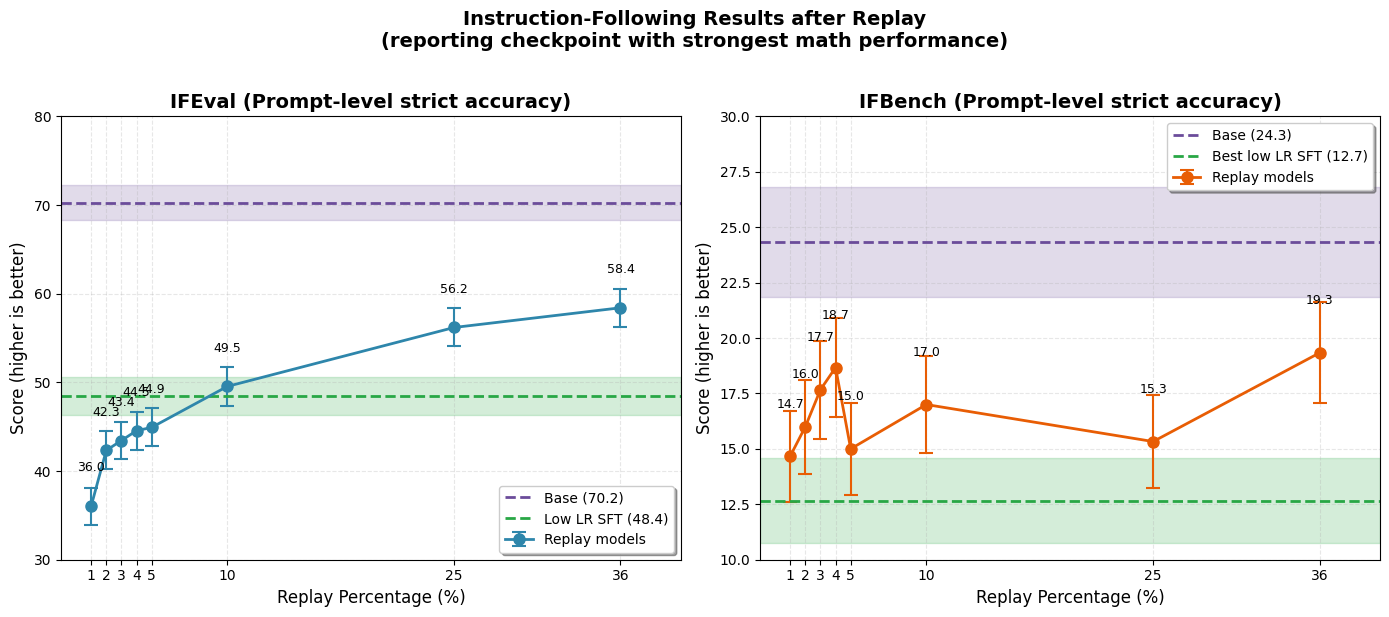

In [9]:
# Extract replay percentages and scores
percentages = []
ifeval_scores = []
ifeval_stderrs = []
ifbench_scores = []
ifbench_stderrs = []

for name, (version, math_score, ifeval_score, ifbench_score) in RESULTS.items():
    if "Replay" in name:
        pct = int(name.split("%")[0])
        percentages.append(pct)
        ifeval_scores.append(ifeval_score[0] * 100)
        ifeval_stderrs.append(ifeval_score[1] * 100)
        ifbench_scores.append(ifbench_score[0] * 100)
        ifbench_stderrs.append(ifbench_score[1] * 100)

# Get baseline values
base_ifeval = RESULTS["Base"][2][0] * 100
base_ifeval_stderr = RESULTS["Base"][2][1] * 100
base_ifbench = RESULTS["Base"][3][0] * 100
base_ifbench_stderr = RESULTS["Base"][3][1] * 100

sft_ifeval = RESULTS["Low LR SFT"][2][0] * 100
sft_ifeval_stderr = RESULTS["Low LR SFT"][2][1] * 100
sft_ifbench = RESULTS["Low LR SFT"][3][0] * 100
sft_ifbench_stderr = RESULTS["Low LR SFT"][3][1] * 100

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- IFEval plot ---
ax1.errorbar(percentages, ifeval_scores, yerr=ifeval_stderrs, fmt='o-', 
            color='#2E86AB', capsize=5, capthick=1.5, 
            elinewidth=1.5, markersize=8, linewidth=2,
            label='Replay models')

ax1.axhline(y=base_ifeval, color='#6B4C9A', linestyle='--', linewidth=2, label=f'Base ({base_ifeval:.1f})')
ax1.axhspan(base_ifeval - base_ifeval_stderr, base_ifeval + base_ifeval_stderr, alpha=0.2, color='#6B4C9A')

ax1.axhline(y=sft_ifeval, color='#28A745', linestyle='--', linewidth=2, label=f'Low LR SFT ({sft_ifeval:.1f})')
ax1.axhspan(sft_ifeval - sft_ifeval_stderr, sft_ifeval + sft_ifeval_stderr, alpha=0.2, color='#28A745')

# Labels for IFEval
label_offsets_ifeval = {
    1:  (0, 25),
    2:  (0, 25),
    3:  (0, 25),
    4:  (0, 25),
    5:  (0, 25),
    10: (0, 25),
    25: (0, 25),
    36: (0, 25),
}
for x, y in zip(percentages, ifeval_scores):
    offset = label_offsets_ifeval.get(x, (0, 12))
    ax1.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                xytext=offset, ha='center', fontsize=9)

ax1.set_xlabel('Replay Percentage (%)', fontsize=12)
ax1.set_ylabel('Score (higher is better)', fontsize=12)
ax1.set_title('IFEval (Prompt-level strict accuracy)', fontsize=14, fontweight='bold')
ax1.legend(frameon=True, fancybox=True, shadow=True, loc='lower right')
ax1.grid(axis='both', alpha=0.3, linestyle='--')
ax1.set_xticks(percentages)
ax1.set_ylim(30, 80)
ax1.set_xlim(-1, 40)

# --- IFBench plot ---
ax2.errorbar(percentages, ifbench_scores, yerr=ifbench_stderrs, fmt='o-', 
            color='#E85D04', capsize=5, capthick=1.5, 
            elinewidth=1.5, markersize=8, linewidth=2,
            label='Replay models')

ax2.axhline(y=base_ifbench, color='#6B4C9A', linestyle='--', linewidth=2, label=f'Base ({base_ifbench:.1f})')
ax2.axhspan(base_ifbench - base_ifbench_stderr, base_ifbench + base_ifbench_stderr, alpha=0.2, color='#6B4C9A')

ax2.axhline(y=sft_ifbench, color='#28A745', linestyle='--', linewidth=2, label=f'Best low LR SFT ({sft_ifbench:.1f})')
ax2.axhspan(sft_ifbench - sft_ifbench_stderr, sft_ifbench + sft_ifbench_stderr, alpha=0.2, color='#28A745')

# Labels for IFBench
label_offsets_ifbench = {
    1:  (0, 35),
    2:  (0, 35),
    3:  (0, 35),
    4:  (0, 35),
    5:  (0, 35),
    10: (0, 35),
    25: (0, 35),
    36: (0, 35),
}
for x, y in zip(percentages, ifbench_scores):
    offset = label_offsets_ifbench.get(x, (0, 12))
    ax2.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                xytext=offset, ha='center', fontsize=9)

ax2.set_xlabel('Replay Percentage (%)', fontsize=12)
ax2.set_ylabel('Score (higher is better)', fontsize=12)
ax2.set_title('IFBench (Prompt-level strict accuracy)', fontsize=14, fontweight='bold')
ax2.legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
ax2.grid(axis='both', alpha=0.3, linestyle='--')
ax2.set_xticks(percentages)
ax2.set_ylim(10, 30)
ax2.set_xlim(-1, 40)

fig.suptitle('Instruction-Following Results after Replay\n(reporting checkpoint with strongest math performance)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

['xstest', 'wildjailbreak:benign', 'Average']
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
WildTeaming paper (https://arxiv.org/pdf/2406.18510v1) mentions refusal to answer (RTA) where lower is better. but the name 'macro_asr' seems incorrect
Found 12 results at ../safety-eval/generat

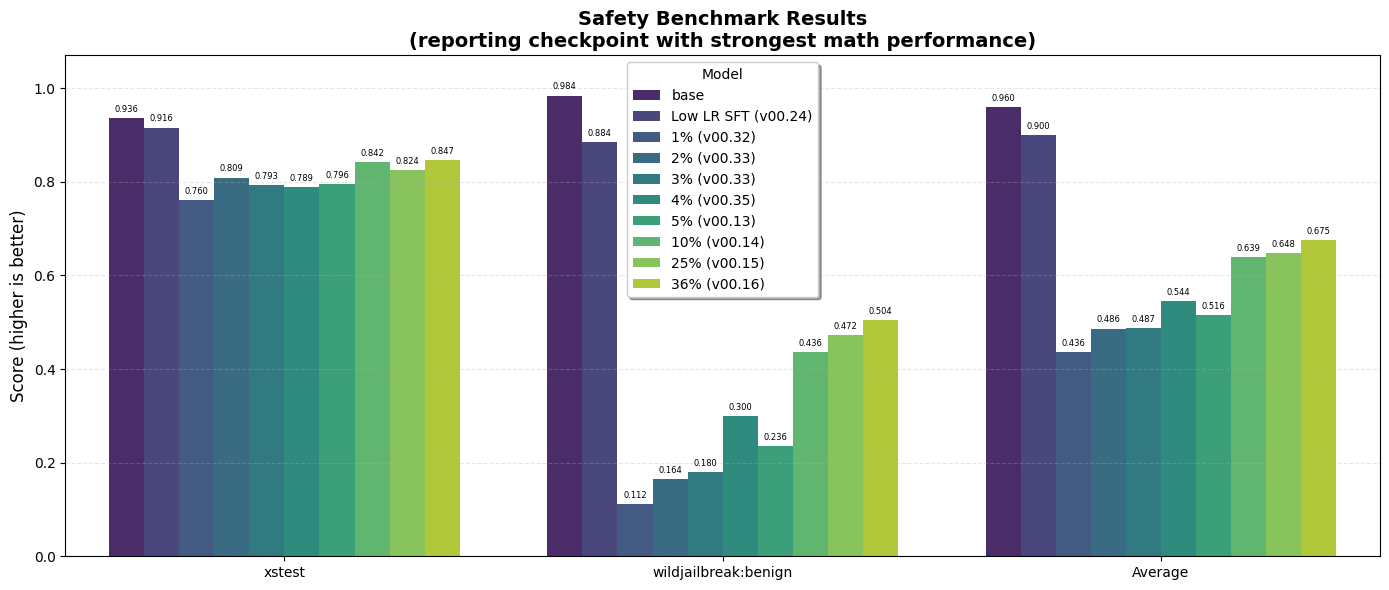

In [10]:
root_file_path = "../safety-eval/generation_results/"
model = "Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00."

safety_benchmark_configs = [
    # ('wildguardtest', 'inverted_micro_harm_lower'),
    # ('harmbench', 'inverted_micro_asr_lower'),
    # ('toxigen', 'safe_overall'),
    # ('do_anything_now', 'inverted_macro_asr'),
    # ('wildjailbreak:harmful', 'inverted_macro_asr'),
    # ('trustllm_jailbreaktrigger', 'inverted_macro_asr'),
    ('xstest', 'overall_accuracy'),
    ('wildjailbreak:benign', 'macro_asr'),
]

benchmarks = [benchmark[0] for benchmark in safety_benchmark_configs] + ["Average"]
print(benchmarks)

### do it for base
base_path = root_file_path + "meta-llama/Llama-3.1-8B-Instruct" + "/base/metrics_base_main.json"
base_values = retrieve_results(results_json_path=base_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)


### do it for low lr sft
low_lr_path = root_file_path + model + "24" + "/SFT/metrics_SFT_main.json"
low_lr_values = retrieve_results(results_json_path=low_lr_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)

### do it for low replay values
low_replay_values = []
for i in range(32,36):
    version_id = str(i)
    low_replay_path = root_file_path + model + version_id + "/SFT/metrics_SFT_main.json"
    low_replay_values += retrieve_results(results_json_path=low_replay_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
print(f"Found {len(low_replay_values)} results at {low_replay_path}")
    
### do it for high replay values
high_replay_values = []
for i in range(13,17):
    version_id = str(i)
    high_replay_path = root_file_path + model + version_id + "/SFT/metrics_SFT_main.json"
    high_replay_values += retrieve_results(results_json_path=high_replay_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
print(f"Found {len(high_replay_values)} results at {high_replay_path}")
    
    
n = 1 + 1 + 4 + 4
print(len(benchmarks * n))
print(len(base_values))
print(len(low_lr_values))
print(len(base_values + low_lr_values + low_replay_values + high_replay_values))


df = pd.DataFrame({
    'Benchmark': benchmarks * n,
    'Value': base_values + low_lr_values + low_replay_values + high_replay_values,
    'Model': ['base'] * len(benchmarks) + ['Low LR SFT (v00.24)'] * len(benchmarks) + ['1% (v00.32)'] * len(benchmarks) + ['2% (v00.33)'] * len(benchmarks)  + ['3% (v00.33)'] * len(benchmarks) + ['4% (v00.35)'] * len(benchmarks) + ['5% (v00.13)'] * len(benchmarks) + ['10% (v00.14)'] * len(benchmarks) + ['25% (v00.15)'] * len(benchmarks) + ['36% (v00.16)'] * len(benchmarks)
})

fig, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("viridis", n)
bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette)

# again we add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Safety Benchmark Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1 * 1.07) # trying to give room for labels
plt.tight_layout()
plt.show()

### Sec 3.3: Dynamic Fine-tuning

**Figure 5: Dynamic Fine-tuning results**

### Sec 3.4: Exponential Moving Average

**Figure 6: Exponential Moving Average results - safety**

['wildguardtest', 'harmbench', 'toxigen', 'do_anything_now', 'wildjailbreak:harmful', 'trustllm_jailbreaktrigger', 'xstest', 'Average']
32
32
32


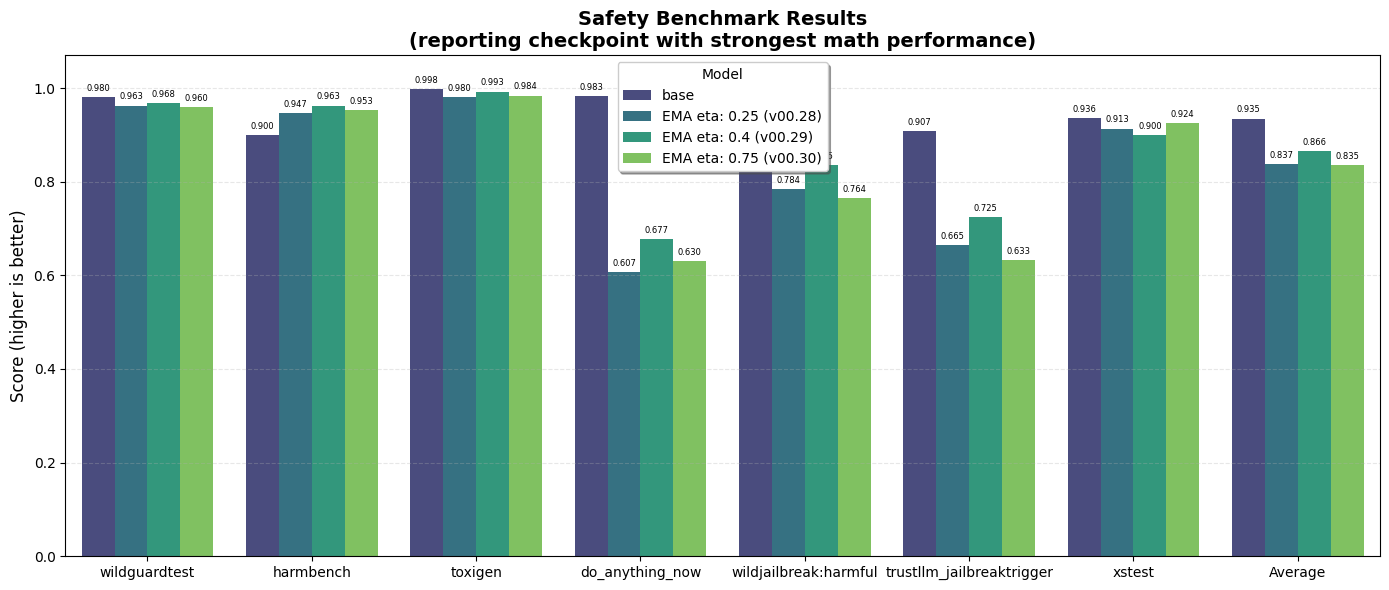

In [11]:
root_file_path = "../safety-eval/generation_results/"
model = "Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00."

safety_benchmark_configs = [
    ('wildguardtest', 'inverted_micro_harm_lower'),
    ('harmbench', 'inverted_micro_asr_lower'),
    ('toxigen', 'safe_overall'),
    ('do_anything_now', 'inverted_macro_asr'),
    ('wildjailbreak:harmful', 'inverted_macro_asr'),
    ('trustllm_jailbreaktrigger', 'inverted_macro_asr'),
    ('xstest', 'overall_accuracy'),
]
benchmarks = [benchmark[0] for benchmark in safety_benchmark_configs] + ["Average"]
print(benchmarks)

### do it for base
base_path = root_file_path + "meta-llama/Llama-3.1-8B-Instruct" + "/base/metrics_base_main.json"
base_values = retrieve_results(results_json_path=base_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
low_lr_values = []
for i in range(28,31):
    version_id_unpadded = str(i)
    version_id = "0" + version_id_unpadded if len(version_id_unpadded) == 1 else version_id_unpadded # turning "7" into "07"
    low_lr_path = root_file_path + model + version_id + "/SFT/metrics_SFT_main.json"
    low_lr_values += retrieve_results(results_json_path=low_lr_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
n = 4
print(len(benchmarks * n))
print(len(base_values + low_lr_values))
print(len(['base'] * len(benchmarks) + ['EMA eta: 0.25 (v00.28)'] * len(benchmarks) + ['EMA eta: 0.4 (v00.29)'] * len(benchmarks) + ['EMA eta: 0.75 (v00.30)'] * len(benchmarks) ))

df = pd.DataFrame({
    'Benchmark': benchmarks * n,
    'Value': base_values + low_lr_values,
    'Model': ['base'] * len(benchmarks) + ['EMA eta: 0.25 (v00.28)'] * len(benchmarks) + ['EMA eta: 0.4 (v00.29)'] * len(benchmarks) + ['EMA eta: 0.75 (v00.30)'] * len(benchmarks)
})

fig, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("viridis", n)
bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette)

# again we add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Safety Benchmark Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1 * 1.07) # trying to give room for labels
plt.tight_layout()
plt.show()

### Sec 3.5: Reinforcement Learning with Verifiable Rewards

**Figure 7: RLVR results**

### Sec 3.6: Comparison of Best Checkpoints

In [12]:
print("CURRENTLY HARDCODING VALS, SHOULD CHANGE THIS BEFORE SUBMISSION!")
print("IDEALLY A BENCHMARKING SCRIPT THAT CREATES ALL RESULTS FOR ALL FIGURES INDIVIDUALLY WHICH YOU CAN RUN BEFORE RUNNING ALL THESE!")

CURRENTLY HARDCODING VALS, SHOULD CHANGE THIS BEFORE SUBMISSION!
IDEALLY A BENCHMARKING SCRIPT THAT CREATES ALL RESULTS FOR ALL FIGURES INDIVIDUALLY WHICH YOU CAN RUN BEFORE RUNNING ALL THESE!


In [13]:
# data for MATH-500, IFeval, IFBench from lighteval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

RESULTS = {
    #  Model name                           Version      MATH-500           IFEval             IFBench
    "Base":                                 ("Base",     (0.460, 0.0223),  (0.7024, 0.0197),  (0.2433, 0.0248)),
    "Best low LR SFT":                      ("v00.24",   (0.598, 0.0219),  (0.4843, 0.0215),  (0.1267, 0.0192)),
    "Best Replay":                          ("v00.15",   (0.520, 0.0224),  (0.5619, 0.0214),  (0.1533, 0.0208)),
    "Best DFT":                             ("v00.17",   (0.424, 0.0221),  (0.3771, 0.0209),  (0.1067, 0.0179)),
    "Best EMA eta=0.75":                    ("v00.30",   (0.580, 0.0221),  (0.4695, 0.0215),  (0.1267, 0.0192)),
    "Best CISPO KL_beta=0.001":             ("v00.12",   (0.582, 0.0221),  (0.6784, 0.0201),  (0.2200, 0.0240)),
    "Best CISPO KL_beta=0":                 ("v00.14",   (0.594, 0.0220),  (0.6359, 0.0207),  (0.1900, 0.0227)),
}

BENCHMARKS = ["MATH-500", "IFEval", "IFBench"]

### Figure 8: Math Best checkpoint comparison graphs

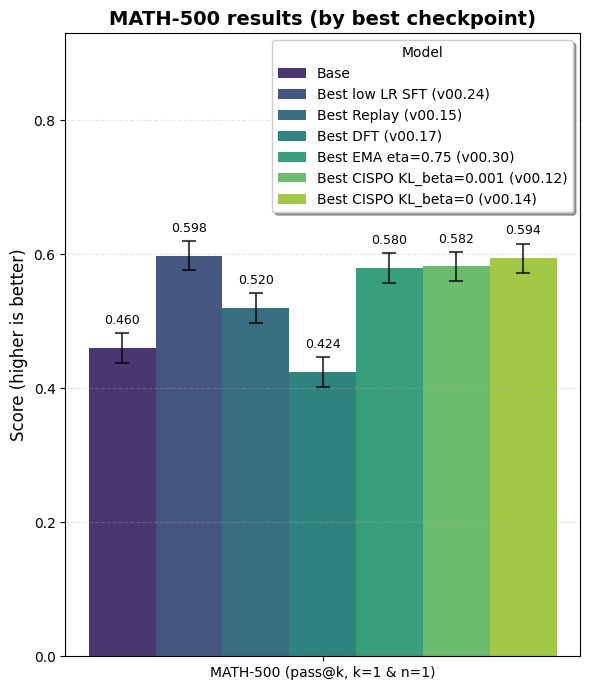

In [14]:
rows = []
for name, (version, *scores) in RESULTS.items():
    label = f"{name} ({version})" if name != "Base" else "Base"
    for bench, (val, stderr) in zip(BENCHMARKS, scores):
        rows.append({"Model": label, "Benchmark": bench, "Value": val, "Stderr": stderr})

df = pd.DataFrame(rows)
df = df[df['Benchmark'].isin(['MATH-500'])]

df['Benchmark'] = 'MATH-500 (pass@k, k=1 & n=1)'

fig, ax = plt.subplots(figsize=(6, 7))
n = len(df)
palette = sns.color_palette("viridis", n)

bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette, errorbar=None)

x_pos = []
y_pos = []
errors = []

# adding stderr vals to all bars
for i, container in enumerate(ax.containers):
    for bar in container:
        x_pos.append(bar.get_x() + bar.get_width() / 2)
        y_pos.append(bar.get_height())
    errors.append(df.iloc[i]['Stderr'])
ax.errorbar(x_pos, y_pos, yerr=errors, fmt='none', 
            color='black', capsize=5, capthick=1.5, 
            elinewidth=1.5, alpha=0.7, zorder=10)

# i prefer adding bar labels on top of bars to actually see the values
for container in ax.containers:
    if isinstance(container, BarContainer):
        ax.bar_label(container, fmt='%.3f', padding=15, fontsize=9)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('MATH-500 results (by best checkpoint)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give room for labels and error bars
ax.set_ylim(0, max(df['Value'] + df['Stderr']) * 1.5)

plt.tight_layout()
plt.show()

### Figure 9: Instruction Following Best checkpoint comparison graphs

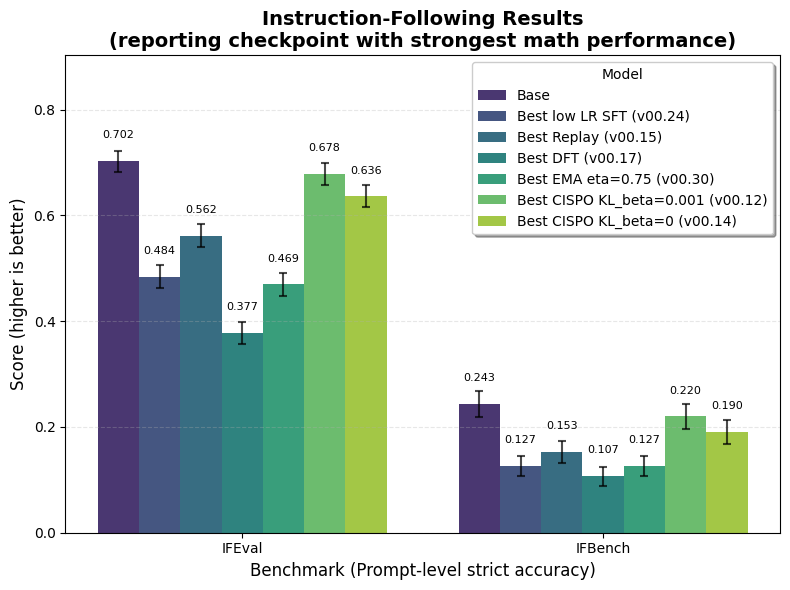

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer

df = pd.DataFrame(rows)

# we select only instruction following benchmarks
df = df[df['Benchmark'].isin(['IFEval','IFBench'])]
fig, ax = plt.subplots(figsize=(8, 6))
n_models = len(df['Model'].unique())
palette = sns.color_palette("viridis", n_models)

bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette, errorbar=None)

benchmarks = df['Benchmark'].unique()
models = df['Model'].unique()

for i, container in enumerate(ax.containers):
    if isinstance(container, BarContainer):
        for j, bar in enumerate(container):
            model = models[i]
            benchmark = benchmarks[j]
            stderr = df[(df['Model'] == model) & (df['Benchmark'] == benchmark)]['Stderr'].values[0]
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()
            if y > 0:  # Only add error bars for non-zero values
                ax.errorbar(x, y, yerr=stderr, fmt='none',
                           color='black', capsize=3, capthick=1.5,
                           elinewidth=1.5, alpha=0.7, zorder=10)

# adding value labels on top of bars again
for container in ax.containers:
    if isinstance(container, BarContainer):
        labels = [f'{v.get_height():.3f}' if v.get_height() > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, padding=15, fontsize=8, rotation=0)

ax.set_xlabel('Benchmark (Prompt-level strict accuracy)', fontsize=12)
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Instruction-Following Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
# ax.legend(title='Model', frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(1.02, 1), loc='upper left')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limit to give room for labels and error bars
ax.set_ylim(0, max(df['Value'] + df['Stderr']) * 1.25)

plt.tight_layout()
plt.show()

### Figure 10: Safety Best checkpoint comparison graphs

Average score for ../safety-eval/generation_results/meta-llama/Llama-3.1-8B-Instruct/base/metrics_base_main.json is 0.9411524161845424
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.24/SFT/metrics_SFT_main.json is 0.8741198310710577
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.15/SFT/metrics_SFT_main.json is 0.8804898568461652
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.17/SFT/metrics_SFT_main.json is 0.7734015353805074
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.30/SFT/metrics_SFT_main.json is 0.8450555764167038
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.12/SFT/metrics_SFT_main-step-000000250.json is 0.773065422878653
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_

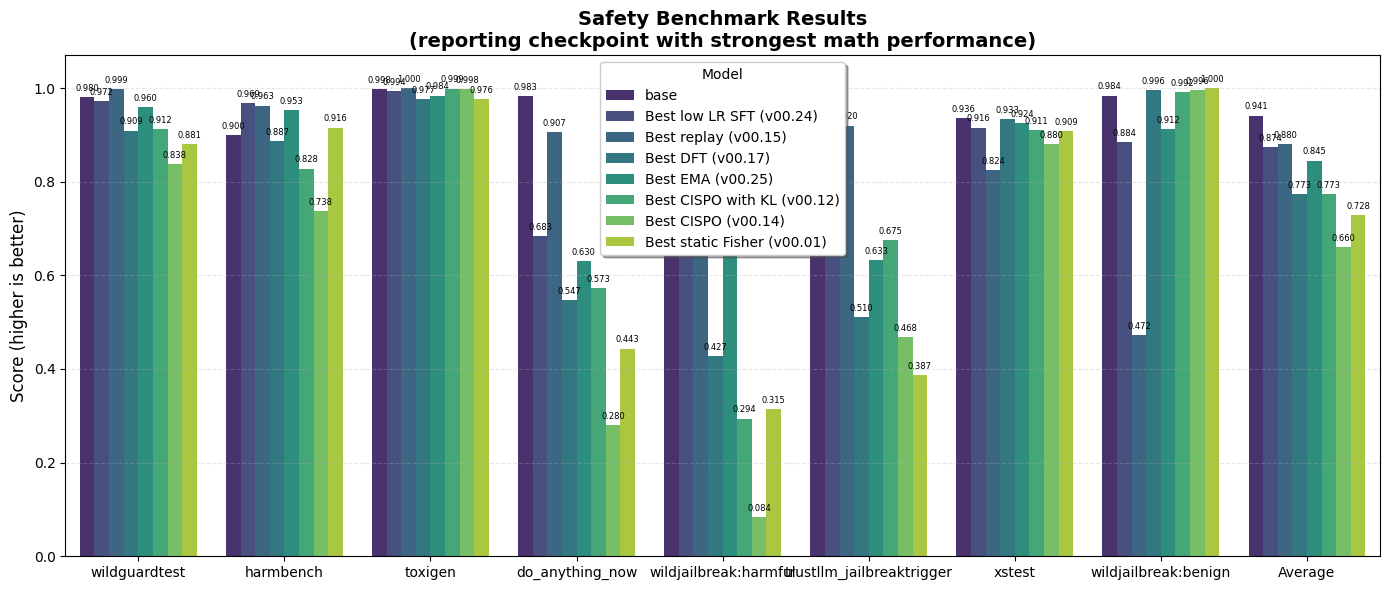

In [2]:
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

root_file_path = "../safety-eval/generation_results/"
model = "Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00."

safety_benchmark_configs = [
    ('wildguardtest', 'inverted_micro_harm_lower'),
    ('harmbench', 'inverted_micro_asr_lower'),
    ('toxigen', 'safe_overall'),
    ('do_anything_now', 'inverted_macro_asr'),
    ('wildjailbreak:harmful', 'inverted_macro_asr'),
    ('trustllm_jailbreaktrigger', 'inverted_macro_asr'),
    ('xstest', 'overall_accuracy'),
    ('wildjailbreak:benign', 'macro_asr'),
]
benchmarks = [benchmark[0] for benchmark in safety_benchmark_configs] + ["Average"]

# quick helper function to retrieve values
def retrieve_results(
    results_json_path: str,
    benchmark_configs: list[tuple[str, str]],
    compute_mean: bool = True,
    ):
    """
    Given a string filepath to a JSON file containing results created by safety-eval, and tuples of benchmarks and requested metrics, returns results as list and optionally the mean at the end.

        Args:
            results_json_path (`str`):
                Filepath of safety-eval generated JSON results file.
            benchmark_configs (`list[tuple[str, str]]`):
                List of tuples, each containing a benchmark and associated metric name. 
            compute_mean (`bool`, defaults to `False`):
                Whether or not to append average score at the end.

        Returns:
            Safety benchmark results as a list
    """
    with open(results_json_path) as fp:
        results_dict = json.load(fp)

    scores = []
    for benchmark, score_name in benchmark_configs:
        scores.append(results_dict[benchmark][score_name])
    
    if compute_mean:
        mean = sum(scores) / len(scores)
        scores.append(mean)
        print(f"Average score for {results_json_path} is {mean}")
    return scores


# Base
# Best SFT
# Best Replay
# Best DFT
# Best EMA
# Best CISPO (KL_beta=0.001)
# Best CISPO (KL_beta=0)

### do it for base
base_path = root_file_path + "meta-llama/Llama-3.1-8B-Instruct" + "/base/metrics_base_main.json"
base_values = retrieve_results(results_json_path=base_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
### this is for best low LR sft v00.24
low_lr_path = root_file_path + model + "24" + "/SFT/metrics_SFT_main.json"
low_lr_values = retrieve_results(results_json_path=low_lr_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
### this is best replay v00.15
best_replay_path = root_file_path + model + "15" + "/SFT/metrics_SFT_main.json"
best_replay_values = retrieve_results(results_json_path=best_replay_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
### this needs to become best DFT v00.17
best_dft_path = root_file_path + model + "17" + "/SFT/metrics_SFT_main.json"
best_dft_values = retrieve_results(results_json_path=best_dft_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
### this needs to become best EMA v00.30
best_ema_path = root_file_path + model + "30" + "/SFT/metrics_SFT_main.json"
best_ema_values = retrieve_results(results_json_path=best_ema_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
    
## this needs to become best CISPO with KL
best_cispo_kl_path = root_file_path + "Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.12" + "/SFT/metrics_SFT_main-step-000000250.json"
best_cispo_kl_values = retrieve_results(results_json_path=best_cispo_kl_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)

## here we will have best CISPO without KL
best_cispo_path = root_file_path + "Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.14" + "/SFT/metrics_SFT_main-step-000000250.json"
best_cispo_values = retrieve_results(results_json_path=best_cispo_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)

## here we will have best static Fisher
best_static_fisher_path = "../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kfisher_v00.01/SFT/metrics_SFT_main.json"
best_static_fisher_values = retrieve_results(results_json_path=best_static_fisher_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)

# now we put into a dataframe and plot
n = 1 + 7
df = pd.DataFrame({
    'Benchmark': benchmarks * n,
    'Value': base_values + low_lr_values + best_replay_values + best_dft_values + best_ema_values + best_cispo_kl_values + best_cispo_values + best_static_fisher_values,
    'Model': ['base'] * len(benchmarks) + ['Best low LR SFT (v00.24)'] * len(benchmarks) + ['Best replay (v00.15)'] * len(benchmarks) + ['Best DFT (v00.17)'] * len(benchmarks) + ['Best EMA (v00.25)'] * len(benchmarks) + ['Best CISPO with KL (v00.12)'] * len(benchmarks) + ['Best CISPO (v00.14)'] * len(benchmarks) + ['Best static Fisher (v00.01)'] * len(benchmarks)
})

fig, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("viridis", n)
bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette)

# again we add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Safety Benchmark Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# trying to give room for labels
ax.set_ylim(0, 1 * 1.07)

plt.tight_layout()
plt.show()

### Average scores only!

Average score for ../safety-eval/generation_results/meta-llama/Llama-3.1-8B-Instruct/base/metrics_base_main.json is 0.9411524161845424
[0.9799732977303071, 0.9, 0.9983571428571428, 0.9833333333333333, 0.8405, 0.9075, 0.9355555555555556, 0.984, 0.9411524161845424]
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.24/SFT/metrics_SFT_main.json is 0.8741198310710577
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.15/SFT/metrics_SFT_main.json is 0.8804898568461652
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.17/SFT/metrics_SFT_main.json is 0.7734015353805074
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00.30/SFT/metrics_SFT_main.json is 0.8450555764167038
Average score for ../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.12/SFT/metrics_SFT_ma

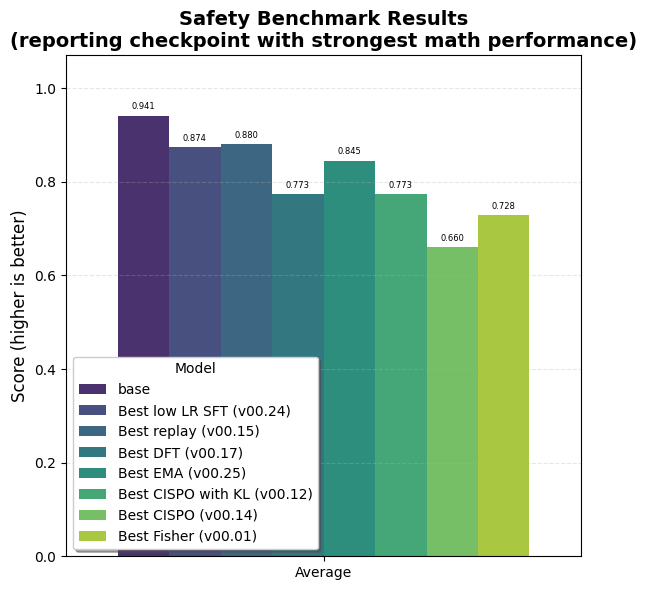

In [17]:
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

root_file_path = "../safety-eval/generation_results/"
model = "Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kv00."

safety_benchmark_configs = [
    ('wildguardtest', 'inverted_micro_harm_lower'),
    ('harmbench', 'inverted_micro_asr_lower'),
    ('toxigen', 'safe_overall'),
    ('do_anything_now', 'inverted_macro_asr'),
    ('wildjailbreak:harmful', 'inverted_macro_asr'),
    ('trustllm_jailbreaktrigger', 'inverted_macro_asr'),
    ('xstest', 'overall_accuracy'),
    ('wildjailbreak:benign', 'macro_asr'),
]
benchmarks = [benchmark[0] for benchmark in safety_benchmark_configs] + ["Average"]

# quick helper function to retrieve values
def retrieve_results(
    results_json_path: str,
    benchmark_configs: list[tuple[str, str]],
    compute_mean: bool = True,
    ):
    """
    Given a string filepath to a JSON file containing results created by safety-eval, and tuples of benchmarks and requested metrics, returns results as list and optionally the mean at the end.

        Args:
            results_json_path (`str`):
                Filepath of safety-eval generated JSON results file.
            benchmark_configs (`list[tuple[str, str]]`):
                List of tuples, each containing a benchmark and associated metric name. 
            compute_mean (`bool`, defaults to `False`):
                Whether or not to append average score at the end.

        Returns:
            Safety benchmark results as a list
    """
    with open(results_json_path) as fp:
        results_dict = json.load(fp)

    scores = []
    for benchmark, score_name in benchmark_configs:
        scores.append(results_dict[benchmark][score_name])
    
    if compute_mean:
        mean = sum(scores) / len(scores)
        scores.append(mean)
        print(f"Average score for {results_json_path} is {mean}")
    return scores


# Base
# Best SFT
# Best Replay
# Best DFT
# Best EMA
# Best CISPO (KL_beta=0.001)
# Best CISPO (KL_beta=0)

### do it for base
base_path = root_file_path + "meta-llama/Llama-3.1-8B-Instruct" + "/base/metrics_base_main.json"
base_values = retrieve_results(results_json_path=base_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
base_values_avg = [base_values[-1]]
print(base_values)

### this is for best low LR sft v00.24
low_lr_path = root_file_path + model + "24" + "/SFT/metrics_SFT_main.json"
low_lr_values = retrieve_results(results_json_path=low_lr_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
low_lr_values_avg = [low_lr_values[-1]]
    
### this is best replay v00.15
best_replay_path = root_file_path + model + "15" + "/SFT/metrics_SFT_main.json"
best_replay_values = retrieve_results(results_json_path=best_replay_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_replay_values_avg = [best_replay_values[-1]]

### this needs to become best DFT v00.17
best_dft_path = root_file_path + model + "17" + "/SFT/metrics_SFT_main.json"
best_dft_values = retrieve_results(results_json_path=best_dft_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_dft_values_avg = [best_dft_values[-1]]
    
### this needs to become best EMA v00.30
best_ema_path = root_file_path + model + "30" + "/SFT/metrics_SFT_main.json"
best_ema_values = retrieve_results(results_json_path=best_ema_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_ema_values_avg = [best_ema_values[-1]]
    
## this needs to become best CISPO with KL
best_cispo_kl_path = root_file_path + "Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.12" + "/SFT/metrics_SFT_main-step-000000250.json"
best_cispo_kl_values = retrieve_results(results_json_path=best_cispo_kl_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_cispo_kl_values_avg = [best_cispo_kl_values[-1]]

## here we will have best CISPO without KL
best_cispo_path = root_file_path + "Neelectric/Llama-3.1-8B-Instruct_GRPO_Math-220kv00.14" + "/SFT/metrics_SFT_main-step-000000250.json"
best_cispo_values = retrieve_results(results_json_path=best_cispo_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_cispo_values_avg = [best_cispo_values[-1]]

## here we will have best static Fisher
best_static_fisher_path = "../safety-eval/generation_results/Neelectric/Llama-3.1-8B-Instruct_SFT_Math-220kfisher_v00.01/SFT/metrics_SFT_main.json"
best_static_fisher_values = retrieve_results(results_json_path=best_static_fisher_path, benchmark_configs=safety_benchmark_configs, compute_mean=True)
best_static_fisher_values_avg = [best_static_fisher_values[-1]]

benchmarks = ["Average"]

# now we put into a dataframe and plot
n = 1 + 7
df = pd.DataFrame({
    'Benchmark': benchmarks * n,
    'Value': base_values_avg + low_lr_values_avg + best_replay_values_avg + best_dft_values_avg + best_ema_values_avg + best_cispo_kl_values_avg + best_cispo_values_avg + best_static_fisher_values_avg,
    'Model': ['base'] * len(benchmarks) + ['Best low LR SFT (v00.24)'] * len(benchmarks) + ['Best replay (v00.15)'] * len(benchmarks) + ['Best DFT (v00.17)'] * len(benchmarks) + ['Best EMA (v00.25)'] * len(benchmarks) + ['Best CISPO with KL (v00.12)'] * len(benchmarks) + ['Best CISPO (v00.14)'] * len(benchmarks) + ['Best Fisher (v00.01)'] * len(benchmarks)
})

fig, ax = plt.subplots(figsize=(6, 6))
palette = sns.color_palette("viridis", n)
bars = sns.barplot(data=df, x='Benchmark', y='Value', hue='Model', ax=ax, palette=palette)

# again we add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Score (higher is better)', fontsize=12)
ax.set_title('Safety Benchmark Results\n(reporting checkpoint with strongest math performance)', fontsize=14, fontweight='bold')
ax.legend(title='Model', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# trying to give room for labels
ax.set_ylim(0, 1 * 1.07)

plt.tight_layout()
plt.show()